**Models to be trained**

Model 1: <br>
- Warm-up learner: Random sampling (randomly labeling a small subset of data to bootstrap the model)
- Hot learner: Uncertainty sampling (choose points the model is least confident about (e.g., predicted probability near 0.5)
- Classifier: Random Forest

Model 2: <br>
- Warm-up learner: Random sampling (randomly labeling a small subset of data to bootstrap the model)
- Hot learner: Expected Model Change (select samples that are expected to cause the biggest change in model params)
- Classifier: Random Forest


In [5]:
with open('seeds.txt', 'r') as f:
    SEEDS = [int(line.strip()) for line in f.readlines()]
    
print(SEEDS)

BATCH_SIZES = [200, 500, 1000, 1500, 2000]

[42, 100, 1, 10, 20]


In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from scipy.stats import entropy  

In [4]:
# Load data
class_df = pd.read_csv("data/elliptic_txs_classes.csv")
edge_df = pd.read_csv("data/elliptic_txs_edgelist.csv")
feature_df = pd.read_csv("data/elliptic_txs_features.csv", header=None)

# Create column names
colnames1 = {'0': 'txId', 1: "time_step"}
colnames2 = {str(ii+2): "local_feature_" + str(ii+1) for ii in range(93)}
colnames3 = {str(ii+95): "aggregate_feature_" + str(ii+1) for ii in range(72)}

colnames = dict(colnames1, **colnames2, **colnames3 )
colnames = {int(jj): item_kk for jj,item_kk in colnames.items()}
feature_df = feature_df.rename(columns=colnames)

# Change unknown class to 3, 2 is licit, 1 is illicit
class_df.loc[class_df['class'] == 'unknown', 'class'] = 3 # note that "unknown" is not counted as a label, just for readability
df = pd.merge(class_df, feature_df ) # merge class csv with features csv

# Split train-test data based on time steps (Weber et al)
df['class'] = df['class'].astype(int)
df['time_step'] = df['time_step'].astype(int)

df_labeled = df[df['class'].isin([1, 2])] # only include labeled samples

df['time_step'] = df['time_step'].astype(int)
train_df = df_labeled[df_labeled['time_step'] <= 34].copy()
test_df = df_labeled[df_labeled['time_step'] >= 35].copy()

# Extract features and labels for train/test
feature_cols = [col for col in df.columns if col.startswith("local_") or col.startswith("aggregate_")]

X_train_full = train_df[feature_cols].values
y_train_full = train_df['class'].map({1:1, 2:0}).values # map labels: illicit=1, licit=0

X_test = test_df[feature_cols].values
y_test = test_df['class'].map({1:1, 2:0}).values

time_steps_test = test_df['time_step'].values

print(X_train_full.shape)
print(X_test.shape)

(29894, 165)
(16670, 165)


In [9]:
# --- Sampling strategies ---

def random_sampling(unlabeled_idx, n_instances, seed=42):
    np.random.seed(seed)
    return np.random.choice(unlabeled_idx, size=n_instances, replace=False)

def uncertainty_sampling(probs, n_instances):
    uncertainty = np.abs(probs[:,1] - 0.5)
    query_idx = np.argsort(uncertainty)[:n_instances]
    return query_idx

def expected_model_change_sampling_rf(probs, n_instances):
    # Approximate EMC for RF by using predictive entropy as proxy
    # probs shape (n_samples, n_classes)
    ent = entropy(probs.T)
    query_idx = np.argsort(ent)[-n_instances:]  # highest entropy (most info gain)
    return query_idx

# --- Active Learning loop for the two models ---

def active_learning_loop(X_train, y_train, X_test, y_test,
                         warmup_size=100, batch_size=50, max_iters=50,
                         hot_learner='uncertainty'):
    compiled_f1_scores = []
    for seed in SEEDS:
        np.random.seed(seed)

        n_samples = X_train.shape[0]
        unlabeled_idx = np.arange(n_samples)
        labeled_idx = np.array([], dtype=int)

        # Warm-up learner: randomly label warmup_size samples
        warmup_idx = random_sampling(unlabeled_idx, warmup_size)
        labeled_idx = np.concatenate([labeled_idx, warmup_idx])
        unlabeled_idx = np.array([i for i in unlabeled_idx if i not in warmup_idx])

        f1_scores = []

        for it in range(max_iters):
            # Train RF classifier on labeled data
            clf = RandomForestClassifier(random_state=seed)
            clf.fit(X_train[labeled_idx], y_train[labeled_idx])

            # Evaluate on test set, F1 for illicit class=1
            y_pred = clf.predict(X_test)
            f1 = f1_score(y_test, y_pred, pos_label=1)
            f1_scores.append(f1)
            if (it + 1) % 10 == 0:
                print(f"Iteration {it+1}/{max_iters}, Labeled size: {len(labeled_idx)}, F1(illicit) = {f1:.4f}")

            if len(unlabeled_idx) == 0:
                print("No more unlabeled samples.")
                break

            # Hot learner selects samples from unlabeled
            probs = clf.predict_proba(X_train[unlabeled_idx])

            if hot_learner == 'uncertainty':
                query_rel_idx = uncertainty_sampling(probs, batch_size)
            elif hot_learner == 'expected_model_change':
                query_rel_idx = expected_model_change_sampling_rf(probs, batch_size)
            else:
                raise ValueError("hot_learner must be 'uncertainty' or 'expected_model_change'")

            query_idx = unlabeled_idx[query_rel_idx]

            # Add queried samples to labeled set, remove from unlabeled set
            labeled_idx = np.concatenate([labeled_idx, query_idx])
            unlabeled_idx = np.array([i for i in unlabeled_idx if i not in query_idx])

        compiled_f1_scores.append(f1_scores)
    return compiled_f1_scores

In [11]:
from matplotlib import pyplot as plt

def compute_confidence_interval(all_f1_scores, batch_size, N_runs=len(SEEDS)):
    max_len = max(len(scores) for scores in all_f1_scores)
    f1_matrix = np.full((N_runs, max_len), np.nan)
    for i, scores in enumerate(all_f1_scores):
        f1_matrix[i, :len(scores)] = scores

    # Median & CI
    median_f1 = np.nanmedian(f1_matrix, axis=0)
    std_f1 = np.nanstd(f1_matrix, axis=0)
    ci_95 = 1.57 * std_f1 / np.sqrt(N_runs)  # Approx 95% CI

    # --- Already computed:
    # f1_matrix = shape (5, N_iter)
    # median_f1 = np.nanmedian(f1_matrix, axis=0)

    # Print Mean F1-score per cycle (across 5 runs)
    mean_f1 = np.nanmean(f1_matrix, axis=0)

    print("\n===== Mean F1-score across 5 runs per cycle =====")
    for i, f1 in enumerate(mean_f1):
        print(f"Cycle {i+1:02d}, Labeled {(i+1)*batch_size} samples: Mean F1 = {f1:.4f}")
    
    x_axis = np.arange(1, len(median_f1)+1) * batch_size

    plt.figure(figsize=(8, 5))
    plt.plot(x_axis, median_f1, marker='o', label='Median F1 (N=5 runs)')
    plt.fill_between(x_axis, median_f1 - ci_95, median_f1 + ci_95, alpha=0.2, label='~95% CI')
    plt.title("Active Learning (EMC) N=5 runs — Median F1 + 95% CI")
    plt.xlabel("Number of Labeled Samples")
    plt.ylabel("Illicit F1-score")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return mean_f1[-1]
    

Iteration 10/50, Labeled size: 1900, F1(illicit) = 0.8316
Iteration 20/50, Labeled size: 3900, F1(illicit) = 0.8307
Iteration 30/50, Labeled size: 5900, F1(illicit) = 0.8296
Iteration 40/50, Labeled size: 7900, F1(illicit) = 0.8301
Iteration 50/50, Labeled size: 9900, F1(illicit) = 0.8258
Iteration 10/50, Labeled size: 1900, F1(illicit) = 0.8291
Iteration 20/50, Labeled size: 3900, F1(illicit) = 0.8266
Iteration 30/50, Labeled size: 5900, F1(illicit) = 0.8274
Iteration 40/50, Labeled size: 7900, F1(illicit) = 0.8270
Iteration 50/50, Labeled size: 9900, F1(illicit) = 0.8204
Iteration 10/50, Labeled size: 1900, F1(illicit) = 0.8272
Iteration 20/50, Labeled size: 3900, F1(illicit) = 0.8271
Iteration 30/50, Labeled size: 5900, F1(illicit) = 0.8221
Iteration 40/50, Labeled size: 7900, F1(illicit) = 0.8254
Iteration 50/50, Labeled size: 9900, F1(illicit) = 0.8294
Iteration 10/50, Labeled size: 1900, F1(illicit) = 0.8242
Iteration 20/50, Labeled size: 3900, F1(illicit) = 0.8270
Iteration 30/5

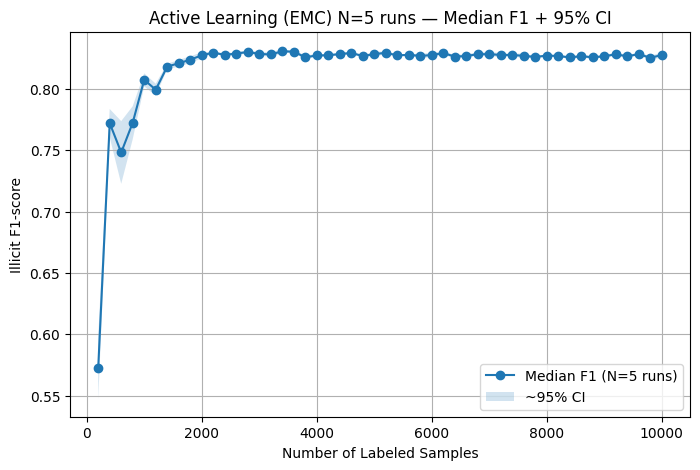

Iteration 10/50, Labeled size: 4600, F1(illicit) = 0.8306
Iteration 20/50, Labeled size: 9600, F1(illicit) = 0.8311
Iteration 30/50, Labeled size: 14600, F1(illicit) = 0.8253
Iteration 40/50, Labeled size: 19600, F1(illicit) = 0.8296
Iteration 50/50, Labeled size: 24600, F1(illicit) = 0.8229
Iteration 10/50, Labeled size: 4600, F1(illicit) = 0.8291
Iteration 20/50, Labeled size: 9600, F1(illicit) = 0.8278
Iteration 30/50, Labeled size: 14600, F1(illicit) = 0.8219
Iteration 40/50, Labeled size: 19600, F1(illicit) = 0.8256
Iteration 50/50, Labeled size: 24600, F1(illicit) = 0.8294
Iteration 10/50, Labeled size: 4600, F1(illicit) = 0.8297
Iteration 20/50, Labeled size: 9600, F1(illicit) = 0.8251
Iteration 30/50, Labeled size: 14600, F1(illicit) = 0.8309
Iteration 40/50, Labeled size: 19600, F1(illicit) = 0.8236
Iteration 50/50, Labeled size: 24600, F1(illicit) = 0.8266
Iteration 10/50, Labeled size: 4600, F1(illicit) = 0.8293
Iteration 20/50, Labeled size: 9600, F1(illicit) = 0.8238
Itera

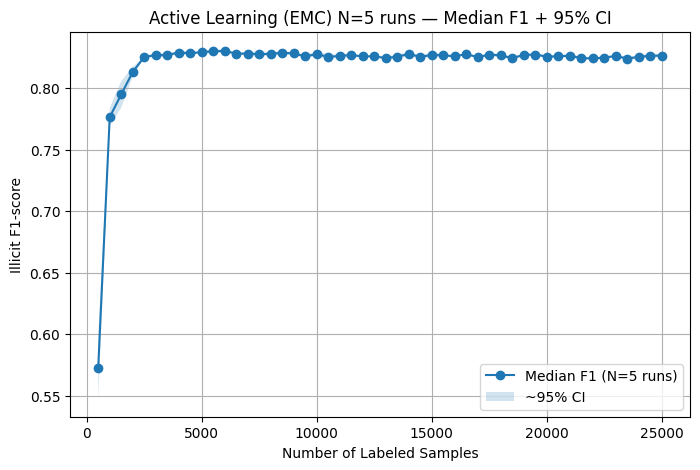

Iteration 10/50, Labeled size: 9100, F1(illicit) = 0.8248
Iteration 20/50, Labeled size: 19100, F1(illicit) = 0.8268
Iteration 30/50, Labeled size: 29100, F1(illicit) = 0.8261
No more unlabeled samples.
Iteration 10/50, Labeled size: 9100, F1(illicit) = 0.8278
Iteration 20/50, Labeled size: 19100, F1(illicit) = 0.8238
Iteration 30/50, Labeled size: 29100, F1(illicit) = 0.8251
No more unlabeled samples.
Iteration 10/50, Labeled size: 9100, F1(illicit) = 0.8245
Iteration 20/50, Labeled size: 19100, F1(illicit) = 0.8242
Iteration 30/50, Labeled size: 29100, F1(illicit) = 0.8230
No more unlabeled samples.
Iteration 10/50, Labeled size: 9100, F1(illicit) = 0.8230
Iteration 20/50, Labeled size: 19100, F1(illicit) = 0.8282
Iteration 30/50, Labeled size: 29100, F1(illicit) = 0.8267
No more unlabeled samples.
Iteration 10/50, Labeled size: 9100, F1(illicit) = 0.8319
Iteration 20/50, Labeled size: 19100, F1(illicit) = 0.8284
Iteration 30/50, Labeled size: 29100, F1(illicit) = 0.8246
No more unla

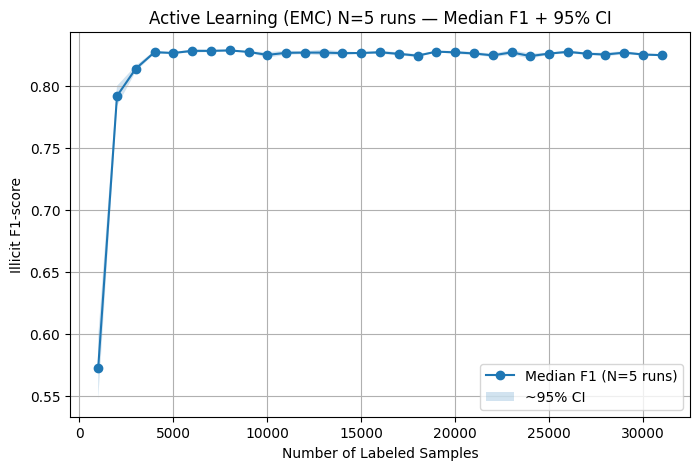

Iteration 10/50, Labeled size: 13600, F1(illicit) = 0.8268
Iteration 20/50, Labeled size: 28600, F1(illicit) = 0.8216
No more unlabeled samples.
Iteration 10/50, Labeled size: 13600, F1(illicit) = 0.8257
Iteration 20/50, Labeled size: 28600, F1(illicit) = 0.8255
No more unlabeled samples.
Iteration 10/50, Labeled size: 13600, F1(illicit) = 0.8251
Iteration 20/50, Labeled size: 28600, F1(illicit) = 0.8264
No more unlabeled samples.
Iteration 10/50, Labeled size: 13600, F1(illicit) = 0.8260
Iteration 20/50, Labeled size: 28600, F1(illicit) = 0.8215
No more unlabeled samples.
Iteration 10/50, Labeled size: 13600, F1(illicit) = 0.8255
Iteration 20/50, Labeled size: 28600, F1(illicit) = 0.8245
No more unlabeled samples.

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 1500 samples: Mean F1 = 0.5655
Cycle 02, Labeled 3000 samples: Mean F1 = 0.7984
Cycle 03, Labeled 4500 samples: Mean F1 = 0.8209
Cycle 04, Labeled 6000 samples: Mean F1 = 0.8280
Cycle 05, Labeled 7500 sampl

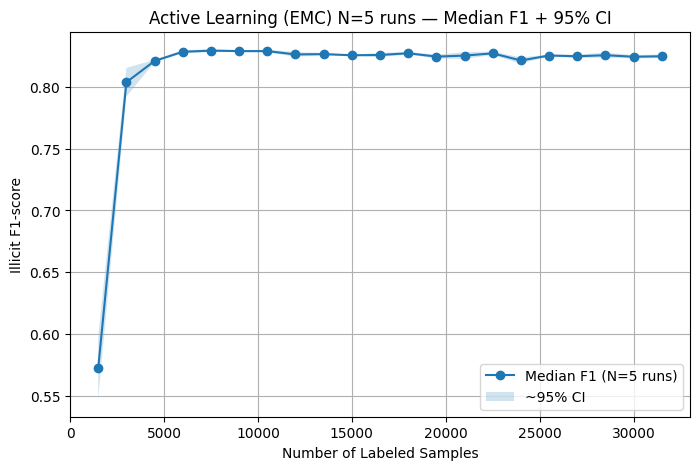

Iteration 10/50, Labeled size: 18100, F1(illicit) = 0.8217
No more unlabeled samples.
Iteration 10/50, Labeled size: 18100, F1(illicit) = 0.8269
No more unlabeled samples.
Iteration 10/50, Labeled size: 18100, F1(illicit) = 0.8280
No more unlabeled samples.
Iteration 10/50, Labeled size: 18100, F1(illicit) = 0.8238
No more unlabeled samples.
Iteration 10/50, Labeled size: 18100, F1(illicit) = 0.8238
No more unlabeled samples.

===== Mean F1-score across 5 runs per cycle =====
Cycle 01, Labeled 2000 samples: Mean F1 = 0.5655
Cycle 02, Labeled 4000 samples: Mean F1 = 0.8067
Cycle 03, Labeled 6000 samples: Mean F1 = 0.8244
Cycle 04, Labeled 8000 samples: Mean F1 = 0.8270
Cycle 05, Labeled 10000 samples: Mean F1 = 0.8278
Cycle 06, Labeled 12000 samples: Mean F1 = 0.8252
Cycle 07, Labeled 14000 samples: Mean F1 = 0.8276
Cycle 08, Labeled 16000 samples: Mean F1 = 0.8275
Cycle 09, Labeled 18000 samples: Mean F1 = 0.8263
Cycle 10, Labeled 20000 samples: Mean F1 = 0.8248
Cycle 11, Labeled 22000

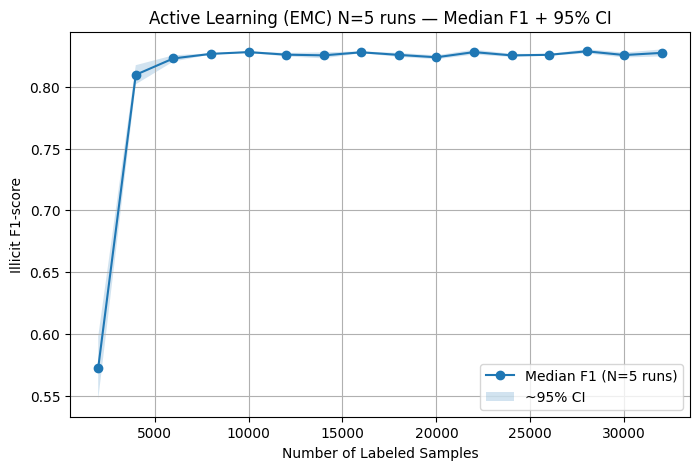

In [14]:
batch_results_1 = {}

for batch_size in BATCH_SIZES:
    f1_model1 = active_learning_loop(
        X_train_full, y_train_full, X_test, y_test,
        batch_size=batch_size, hot_learner='uncertainty'
    )
    batch_results_1[batch_size] = compute_confidence_interval(f1_model1, batch_size=batch_size)

In [16]:
import json

with open("results.json", "r") as f:
    json_input = json.load(f)
    
json_input["Random + Uncertainty Sampling + RF"] = batch_results_1

with open("results.json", "w") as f:
    json.dump(json_input, f, indent=4)

In [15]:
batch_results_2 = {}

for batch_size in BATCH_SIZES:
    f1_model2 = active_learning_loop(
        X_train_full, y_train_full, X_test, y_test,
        batch_size=batch_size, hot_learner='expected_model_change'
    )
    batch_results_2[batch_size] = compute_confidence_interval(f1_model1, batch_size=batch_size)

Iteration 10/50, Labeled size: 1900, F1(illicit) = 0.8246
Iteration 20/50, Labeled size: 3900, F1(illicit) = 0.8289
Iteration 30/50, Labeled size: 5900, F1(illicit) = 0.8273
Iteration 40/50, Labeled size: 7900, F1(illicit) = 0.8285


KeyboardInterrupt: 

In [ ]:
import json

with open("results.json", "r") as f:
    json_input = json.load(f)
    
json_input["Random + EMC + RF"] = batch_results_2

with open("results.json", "w") as f:
    json.dump(json_input, f, indent=4)

# Old code (its in markdown mode)

def uncertainty_sampling(probs, n_instances):
    # probs: shape (n_samples, 2) for class probabilities
    # Select instances closest to 0.5 probability for positive class (illicit=1)
    uncertainty = np.abs(probs[:,1] - 0.5)
    query_idx = np.argsort(uncertainty)[:n_instances]
    return query_idx

# Initialize labeled and unlabeled pools
np.random.seed(42)
initial_label_count = 100

# Start with a small random labeled set
labeled_idx = np.random.choice(len(X_train), size=initial_label_count, replace=False)
unlabeled_idx = np.array([i for i in range(len(X_train)) if i not in labeled_idx])

# Track performance
f1_scores = []

n_queries_per_iter = 50
max_iterations = 30

for it in range(max_iterations):
    # Train model on labeled set
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train[labeled_idx], y_train[labeled_idx])

    # Predict on test set and evaluate
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    f1_scores.append(f1)
    print(f"Iteration {it}: F1 (illicit class) = {f1:.4f}")

    if len(unlabeled_idx) == 0:
        print("No more unlabeled samples to query.")
        break

    # Predict probabilities on unlabeled pool
    probs = clf.predict_proba(X_train[unlabeled_idx])

    # Query uncertain samples
    query_idx_relative = uncertainty_sampling(probs, n_queries_per_iter)
    query_idx = unlabeled_idx[query_idx_relative]

    # Add queried samples to labeled set
    labeled_idx = np.concatenate([labeled_idx, query_idx])

    # Remove queried samples from unlabeled set
    unlabeled_idx = np.array([i for i in unlabeled_idx if i not in query_idx])

# Plot F1 scores over iterations
import matplotlib.pyplot as plt
plt.plot(range(len(f1_scores)), f1_scores, marker='o')
plt.xlabel('Active Learning Iteration')
plt.ylabel('F1 Score (Illicit Class)')
plt.title('Active Learning: Uncertainty Sampling + Random Forest')
plt.grid(True)
plt.show()